## Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/PPE Detection/venv/lib/python3.10/site-packages')

In [7]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageFont
from typing import Iterable

In [5]:
%run '/content/drive/MyDrive/Colab Notebooks/PPE Detection/notebook/utils.ipynb'

## Load Dataset



In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="g8sRlurfp7TqaF6v98V7")
project = rf.workspace("yklee").project("chv-rf6bm")
dataset = project.version(1).download("tensorflow", location="/content/dataset")

dataset_path = "/content/dataset"

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to /content/dataset in tensorflow:: 100%|██████████| 1008/1008 [00:01<00:00, 607.14it/s]


##Dataset

In [8]:
import cv2
import numpy as np

SIZE = 224

def transform_image(img, bbox, crop_bbox, labels):
    xmin, ymin, xmax, ymax = bbox
    crop_xmin, crop_ymin, crop_xmax, crop_ymax = crop_bbox

    transform = A.Compose([
        A.Crop(x_min=crop_xmin, y_min=crop_ymin, x_max=crop_xmax, y_max=crop_ymax),
        A.Resize(width=SIZE, height=SIZE)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    transformed = transform(image=img, bboxes=[[xmin, ymin, xmax, ymax]], class_labels=[labels])
    return transformed

def generate_new_regions(shape, bounding_boxes):
    new_bounding_boxes = []
    for bbox in bounding_boxes:
        xmin, ymin, xmax, ymax = bbox[:4]

        min_left = 0
        max_right = shape[1]
        min_down = 0
        max_up = shape[0]

        for other_bbox in bounding_boxes:
            if np.array_equal(other_bbox, bbox):
                continue

            if other_bbox[0] > xmax or other_bbox[2] < xmin:
                down = 0
                up = shape[0]
            else:
                down = min(other_bbox[3], ymin) if other_bbox[1] <= ymin else 0
                up = max(other_bbox[1], ymax) if other_bbox[3] >= ymax else shape[0]

            if other_bbox[1] > ymax or other_bbox[3] < ymin:
                left = 0
                right = shape[1]
            else:
                left = min(other_bbox[2], xmin) if other_bbox[0] <= xmin else 0
                right = max(other_bbox[0], xmax) if other_bbox[2] >= xmax else shape[1]

            min_left = max(left, min_left)
            max_right = min(right, max_right)
            min_down = max(down, min_down)
            max_up = min(up, max_up)

        expanded_bbox = [min_left, min_down, max_right, max_up]

        new_bounding_boxes.append(expanded_bbox)
    return bounding_boxes, new_bounding_boxes

In [9]:
import albumentations as A

def get_data(path):
  X, Y = [], []
  annotations = pd.read_csv(path+'/_annotations.csv')

  annotations = annotations[annotations['class'] != 0]
  annotations['class'] = annotations['class'].map(lambda x: 0 if x == 1 else 1 if x >= 2 else -1)
  annotations = annotations[annotations['class'] != -1]

  annotations = annotations[(annotations['xmax']-annotations['xmin'])*(annotations['ymax']-annotations['ymin']) > 128] # keep only targets with an area bigger than 128

  file_list = [filename for filename in os.listdir(path) if filename.endswith('.jpg') and filename in annotations['filename'].values]
  for filename in file_list:
    try:
      img = Image.open(os.path.join(path, filename))
      img = np.array(img, dtype=np.uint8)
      rows = annotations.loc[annotations['filename'] == filename]

      bboxes, regions = generate_new_regions(img.shape, rows[['xmin','ymin','xmax','ymax', 'class']].values)

      for i, crop_region in enumerate(regions):
          box = bboxes[i]

          transformed = transform_image(img, box[:4], crop_region, box[4])
          if transformed['class_labels'] and transformed['bboxes']:
            X.append(transformed['image'])
            Y.append(np.concatenate((transformed['class_labels'],
                                    transformed['bboxes'][0])))

    except IOError:
      print('error')

  return np.array(X), np.array(Y, dtype=np.int32)

In [10]:
X_train, Y_train = get_data(dataset_path+'/train')
X_val, Y_val = get_data(dataset_path+'/valid')
X_test, Y_test = get_data(dataset_path+'/test')

In [11]:
print(X_train.shape, Y_train.shape)

(2652, 224, 224, 3) (2652, 5)


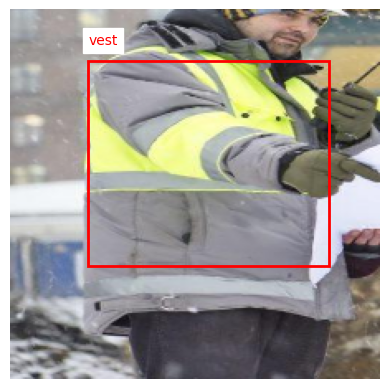

In [23]:
index = random.randint(0,len(X_train)-1)
image = Image.fromarray(X_train[index].astype(np.uint8))
boxes= Y_train[index, 1:]
labels= Y_train[index, 0]

draw(image, boxes, labels)

In [13]:
condition1 = Y_train[:, 2] >= Y_train[:, 4]
condition2 = Y_train[:, 1] >= Y_train[:, 3]

rows = np.where(np.logical_or(condition1, condition2))[0]
X_train = np.delete(X_train, rows, axis=0)
Y_train = np.delete(Y_train, rows, axis=0)

##Data Augmentation

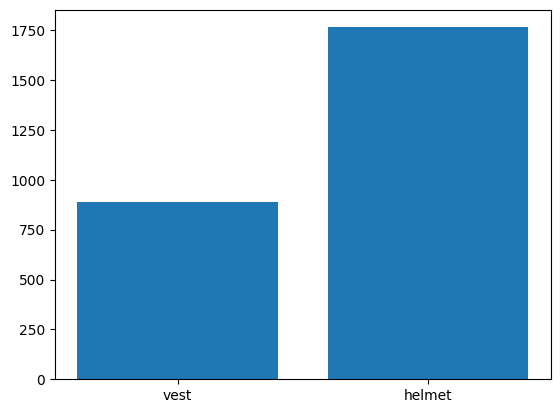

[ 888 1764]


<Figure size 640x480 with 0 Axes>

In [14]:
_, counts = np.unique(Y_train[:, 0], return_counts=True)
labels=['vest', 'helmet']
plt.bar(labels, counts, width=0.8)
plt.show()
print(counts)
plt.clf()

In [15]:
import albumentations as A

def rebalance(X, Y):
    unique, counts = np.unique(Y[:, 0], return_counts=True)
    samples = [np.max(counts)-count for count in counts]
    probabilities = [min(1, sample / len(Y[Y[:, 0]==label])) for sample,label in zip(samples,unique)]

    new_X = []
    new_Y = []

    for x, y in zip(X, Y):
        p = probabilities[y[0]]
        transform = A.Compose([
            A.OneOf([
                A.OneOf([
                    A.HorizontalFlip(),
                    A.VerticalFlip(),
                    A.RandomRotate90(),
                ]),
                A.OneOf([
                    A.RandomBrightnessContrast(),
                    A.ColorJitter(saturation=0.25, brightness=0.25),
                    A.ToGray()
                ]),
            ], p=p),
        ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

        transformed = transform(image=x, bboxes=[y[1:]], class_labels=[y[0]])
        if transformed['class_labels'] and transformed['bboxes'] and not np.array_equal(transformed['image'], x):
            new_X.append(transformed['image'])
            new_Y.append(np.concatenate((transformed['class_labels'], transformed['bboxes'][0])))

    X = np.append(X, np.array(new_X, dtype=np.int32), axis=0)
    Y = np.append(Y, np.array(new_Y, dtype=np.int32), axis=0)
    return X, Y


X_train, Y_train = rebalance(X_train, Y_train)

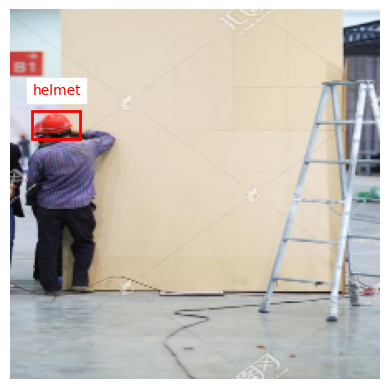

In [16]:
index = random.randint(0,len(X_train)-1)
image = Image.fromarray(X_train[index].astype(np.uint8))
boxes= Y_train[index, 1:]
labels= Y_train[index, 0]

draw(image, boxes, labels)

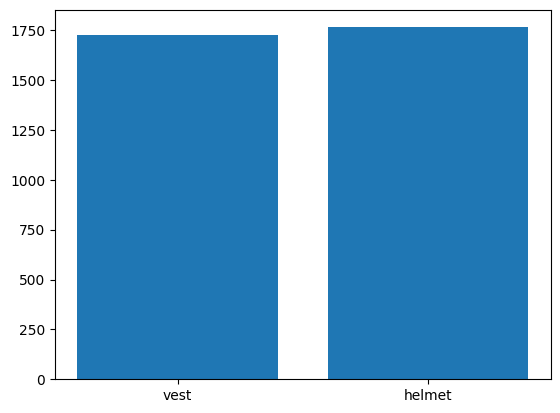

[1724 1764]


<Figure size 640x480 with 0 Axes>

In [17]:
_, counts = np.unique(Y_train[:, 0], return_counts=True)
labels=['vest', 'helmet']
plt.bar(labels, counts, width=0.8)
plt.show()
print(counts)
plt.clf()

## Store Preprocessed Dataset
At this point, all we have to do is to store the dataset divided into the three sets, applying data augmentation and image cropping.

To begin with, we prepare all the necessary folders.

In [18]:
dataset_path = "/content/dataset"
train_path = dataset_path + "/train"
val_path = dataset_path + "/valid"
test_path = dataset_path + "/test"

In [19]:
shutil.rmtree(dataset_path, ignore_errors=True)

# create the structure
os.makedirs(dataset_path)
os.makedirs(train_path)
os.makedirs(val_path)
os.makedirs(test_path)


In [20]:
col_names = ['class','xmin','ymin','xmax','ymax']

#Store training set
filenames = ['ppe_{:04d}.jpg'.format(i) for i, _ in enumerate(X_train)]
[Image.fromarray(img.astype(np.uint8)).save(os.path.join(train_path, filename)) for img, filename in zip(X_train, filenames)]

annotations = pd.DataFrame(Y_train, columns=col_names)
annotations.insert(0, 'filename', filenames)
annotations.to_csv(os.path.join(train_path, '_annotations.csv'))

#Store validation set
filenames = ['ppe_{:04d}.jpg'.format(i) for i, _ in enumerate(X_val)]
[Image.fromarray(img.astype(np.uint8)).save(os.path.join(val_path, filename)) for img, filename in zip(X_val, filenames)]

annotations = pd.DataFrame(Y_val, columns=col_names)
annotations.insert(0, 'filename', filenames)
annotations.to_csv(os.path.join(val_path, '_annotations.csv'))

#Store test set
filenames = ['ppe_{:04d}.jpg'.format(i) for i, _ in enumerate(X_test)]
[Image.fromarray(img.astype(np.uint8)).save(os.path.join(test_path, filename)) for img, filename in zip(X_test, filenames)]

annotations = pd.DataFrame(Y_test, columns=col_names)
annotations.insert(0, 'filename', filenames)
annotations.to_csv(os.path.join(test_path, '_annotations.csv'))

In [21]:
!zip -r "/content/drive/MyDrive/Colab Notebooks/PPE Detection/dataset.zip" "dataset"

updating: dataset/ (stored 0%)
updating: dataset/train/ (stored 0%)
updating: dataset/train/ppe_1667.jpg (deflated 3%)
updating: dataset/train/ppe_3302.jpg (deflated 2%)
updating: dataset/train/ppe_0826.jpg (deflated 2%)
updating: dataset/train/ppe_2564.jpg (deflated 1%)
updating: dataset/train/ppe_2262.jpg (deflated 2%)
updating: dataset/train/ppe_2169.jpg (deflated 1%)
updating: dataset/train/ppe_1479.jpg (deflated 1%)
updating: dataset/train/ppe_0441.jpg (deflated 5%)
updating: dataset/train/ppe_1155.jpg (deflated 1%)
updating: dataset/train/ppe_2504.jpg (deflated 2%)
updating: dataset/train/ppe_3473.jpg (deflated 2%)
updating: dataset/train/ppe_1177.jpg (deflated 2%)
updating: dataset/train/ppe_0465.jpg (deflated 1%)
updating: dataset/train/ppe_1212.jpg (deflated 1%)
updating: dataset/train/ppe_3197.jpg (deflated 1%)
updating: dataset/train/ppe_3089.jpg (deflated 2%)
updating: dataset/train/ppe_3428.jpg (deflated 2%)
updating: dataset/train/ppe_1751.jpg (deflated 4%)
updating: data

In [22]:
import zipfile
from tqdm import tqdm

file_path = '/content/drive/MyDrive/Colab Notebooks/PPE Detection/dataset.zip'
dest_path = '/content/drive/MyDrive/Colab Notebooks/PPE Detection/'

shutil.rmtree(dest_path+'/dataset', ignore_errors=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
  for member in tqdm(zip_ref.namelist(), desc="Extracting"):
    zip_ref.extract(member, dest_path)

Extracting: 100%|██████████| 4800/4800 [00:42<00:00, 113.40it/s]
